In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle
import datetime as dt

from dain import Adaptive_Normalizer_Layer

import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import *#Reshape, LSTM, Dense, Bidirectional, GRU, Dropout, Input, Embedding, MultiHeadAttention, LayerNormalization, Conv1D, GlobalMaxPooling1D
import tensorflow_probability as tfp
from fit_one_cycle import OneCycleScheduler
from lr_finder import LRFinder

from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# .filter(regex=r'^(?!news_.*$)|(?=.*news__High|news__Medium)')

df_1T = pd.read_parquet('df_CNN_LSTM_1T.parquet').reset_index().reset_index().set_index('datetime', drop=True)
df_5T = pd.read_parquet('df_CNN_LSTM_5T.parquet')
df_15T = pd.read_parquet('df_CNN_LSTM_15T.parquet')
df_30T = pd.read_parquet('df_CNN_LSTM_30T.parquet')
df_1H = pd.read_parquet('df_CNN_LSTM_1H.parquet')
df_2H = pd.read_parquet('df_CNN_LSTM_2H.parquet')
df_4H = pd.read_parquet('df_CNN_LSTM_4H.parquet')
df_1B = pd.read_parquet('df_CNN_LSTM_1B.parquet')

In [3]:
# Define the data generator function
def normalize_and_yield(batch_data, batch_targets):
    # Convert to np.array
    batch_data = np.asarray(batch_data)
    batch_targets = np.asarray(batch_targets)
    
    # Normalize
    cols_to_standardize = ['open_es', 'high_es', 'low_es', 'close_es', 'open_nq', 'high_nq', 'low_nq', 'close_nq', 'open_dxy', 'high_dxy', 'low_dxy', 'close_dxy', 'weekly_open', 'weekly_close', 'daily_open']
    cols_to_standardize = [df_1B.columns.get_loc(c) for c in cols_to_standardize]
    for i in range(batch_data.shape[1]):
        a = batch_data[:, i, :, cols_to_standardize]
        scaler = StandardScaler()
        batch_data[:, i, :, cols_to_standardize] = scaler.fit_transform(a.reshape(-1, a.shape[-1])).reshape(a.shape[0], a.shape[1], a.shape[2])

    batch_data = batch_data.astype('float32')
    batch_data = np.split(batch_data, 6, axis=1)
    batch_data = [element.squeeze(axis=1) for element in batch_data]

    return np.asarray(batch_data), batch_targets.astype('float32')


def data_generator(data, window_size, batch_size, indices):
    batch_data = []
    batch_targets = []
    i=0
    for index in indices:
        dt_index = df_1T.iloc[index].name
        input_sequences = np.array([
            df_1T.loc[:dt_index-pd.Timedelta(minutes=1)][-window_size:].fillna(0).drop(columns='index').values.astype('float32'),
            df_5T.loc[:dt_index-pd.Timedelta(minutes=5)][-window_size:].fillna(0).values.astype('float32'),
            df_15T.loc[:dt_index-pd.Timedelta(minutes=15)][-window_size:].fillna(0).values.astype('float32'),
            df_1H.loc[:dt_index-pd.Timedelta(hours=1)][-window_size:].fillna(0).values.astype('float32'),
            df_4H.loc[:dt_index-pd.Timedelta(hours=4)][-window_size:].fillna(0).values.astype('float32'),
            df_1B.loc[:dt_index.normalize()-pd.Timedelta(days=1)][-window_size:].fillna(0).values.astype('float32')
        ])

        # Extract the target high and low values
        target_high_es = df_1T[index : index+151].high_es.max()
        target_low_es = df_1T[index : index+151].low_es.min()
        target_high_nq = df_1T[index : index+151].high_nq.max()
        target_low_nq = df_1T[index : index+151].low_nq.min()

        # Add the input sequence and targets to the batch
        batch_data.append(input_sequences)
        batch_targets.append([target_high_es, target_low_es, target_high_nq, target_low_nq])
        print(i, len(indices)) if i % 256 == 0 else None
        i += 1
        
    return normalize_and_yield(batch_data, batch_targets)


                
# Set the window size and batch size
window_size = 90 # minutes in 252 days (1 year of trading days)
batch_size = 64
num_features = df_1T.shape[1]-1

# Get the indices for training, validation, and testing splits
# Filter the indices to exclude those with insufficient historical data
data_indices = df_1T.loc[(df_1T.index.hour == 9) & (df_1T.index.minute == 30) & (df_1T.index.dayofweek < 5) & (df_1T['index'] > df_1T[df_1B[:window_size+1].iloc[-1].name:].iloc[0]['index'].astype(int))]['index'].to_numpy()
X, y = data_generator(df_1T, window_size, batch_size, data_indices)

separate_nq = 0
if separate_nq:
    X_nq = X
    X_nq[:, :, :, [0,1,2,3,7,8,9,10]] = X_nq[:, :, :, [7,8,9,10,0,1,2,3]]
    X = np.concatenate([X, X_nq], axis=1)

    y_nq = y[:,2:]
    y = np.concatenate([y[:,:2], y_nq])


# Get the total number of samples and calculate the split index
num_samples = X.shape[1]
train_ratio = 0.9
split_index = int(num_samples * train_ratio)

# Shuffle the indices
np.random.seed(42)
shuffle = 1
indices = np.random.permutation(np.arange(num_samples)) if shuffle else np.arange(num_samples)

# Split the array based on the shuffled indices
X_train = list(X[:, indices[:split_index], :, :])
y_train = y[indices[:split_index]]
X_test = list(X[:, indices[split_index:], :, :])
y_test = y[indices[split_index:]]

0 3597
256 3597
512 3597
768 3597
1024 3597
1280 3597
1536 3597
1792 3597
2048 3597
2304 3597
2560 3597
2816 3597
3072 3597
3328 3597
3584 3597


In [4]:
# # Reshape X_train to a 2D array
# X_train = np.asarray(X_train)
# orig_shape = X_train.shape

# # Fit the scaler to the data and transform X_train
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train.reshape((-1, X_train.shape[-1])))

# # Reshape X_train_scaled_2d back to the original shape
# X_train = list(X_train.reshape(orig_shape))

In [5]:
# Define the Transformer model

# Define the input layer
inputs_1T = Input(shape=(window_size, num_features), batch_size=batch_size)
inputs_5T = Input(shape=(window_size, num_features), batch_size=batch_size)
inputs_15T = Input(shape=(window_size, num_features), batch_size=batch_size)
inputs_1H = Input(shape=(window_size, num_features), batch_size=batch_size)
inputs_4H = Input(shape=(window_size, num_features), batch_size=batch_size)
inputs_1B = Input(shape=(window_size, num_features), batch_size=batch_size)

main_inputs = [inputs_1T, inputs_5T, inputs_15T, inputs_1H, inputs_4H, inputs_1B]

# Define the Convolutional model
timeframes = [1, 5, 15, 60, 240, 1440]  # in minutes
conv_outputs = []
for timeframe, inp in zip(timeframes, main_inputs):
    x = Dense(100, activation='relu')(inp)
    x = Dense(100, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    #x = Dense(10, activation='relu')(x)
    conv_outputs.append(x)
    
# Concatenate the output
output = Concatenate(axis=1)(conv_outputs)
output = GlobalAveragePooling1D()(output)
output = Dense(1)(output)

# Define the model with two outputs
model = Model(inputs=main_inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['mse'], run_eagerly=False)

Metal device set to: Apple M1 Pro


In [6]:
#model.summary()
#tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1))(output1)

#### layer activations
#### tensorboard

Epoch 1/300
90/90 [==============================] - 6s 50ms/step - loss: 956.7102 - mse: 2154963.0000 - val_loss: 182.8705 - val_mse: 44661.7773
Epoch 2/300
 3/90 [>.............................] - ETA: 2s - loss: 204.4283 - mse: 50921.5938

/Users/kush/Documents/DS/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 3s 38ms/step - loss: 174.2145 - mse: 46697.2852 - val_loss: 142.0882 - val_mse: 26541.0977
Epoch 3/300
90/90 [==============================] - 3s 39ms/step - loss: 132.4136 - mse: 27319.8945 - val_loss: 105.7478 - val_mse: 20486.5996
Epoch 4/300
90/90 [==============================] - 4s 39ms/step - loss: 82.0241 - mse: 12323.7275 - val_loss: 83.3083 - val_mse: 10690.0859
Epoch 5/300
90/90 [==============================] - 3s 38ms/step - loss: 62.5967 - mse: 7984.4482 - val_loss: 65.0191 - val_mse: 8433.5986
Epoch 6/300
90/90 [==============================] - 3s 38ms/step - loss: 49.1502 - mse: 5144.5239 - val_loss: 44.2454 - val_mse: 4860.3887
Epoch 7/300
90/90 [==============================] - 3s 36ms/step - loss: 42.2429 - mse: 4025.5720 - val_loss: 46.4736 - val_mse: 4281.7632
Epoch 8/300
90/90 [==============================] - 3s 37ms/step - loss: 41.1319 - mse: 3648.2239 - val_loss: 55.2046 - val_mse: 6224.0034
Epoch 9/300
90/90 [===

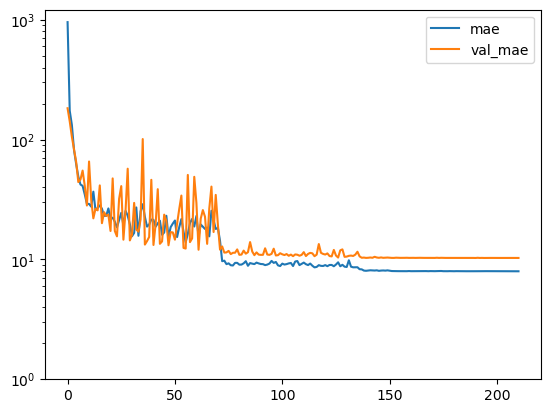

In [7]:
epochs = 300
lr = 1e-2

train_steps_per_epoch = len(X_train[0]) // batch_size

#lr_schedule = OneCycleScheduler(lr, train_steps_per_epoch)
lr_schedule = OneCycleScheduler(lr_max=lr, steps=train_steps_per_epoch, reduce_lr_patience=10, reduce_lr_factor=0.1)
lr_finder = LRFinder()

log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Define the Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor for early stopping
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the best model weights based on the monitored metric
)

# Define the ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint(
    'best_model_test.h5',  # Filepath to save the best model
    monitor='val_loss',  # Metric to monitor for saving the best model
    save_best_only=True  # Save only the best model based on the monitored metric
)

# scaler_es = MinMaxScaler()
# scaler_nq = MinMaxScaler()
# y_temp = np.concatenate([scaler_es.fit_transform(y[:y.shape[0]//2]), scaler_nq.fit_transform(y[y.shape[0]//2:])])

history = model.fit(X_train, y_train[:,1], epochs=epochs, validation_split=0.11111,
                    callbacks=[lr_schedule, early_stopping, tensorboard_callback, checkpoint])

# Plot the training and validation loss and MAE
plt.semilogy(history.history['loss'], label='mae')
plt.semilogy(history.history['val_loss'], label='val_mae')
plt.ylim(ymin=1)  # Set the y-axis minimum value to 0
plt.legend()
plt.show()

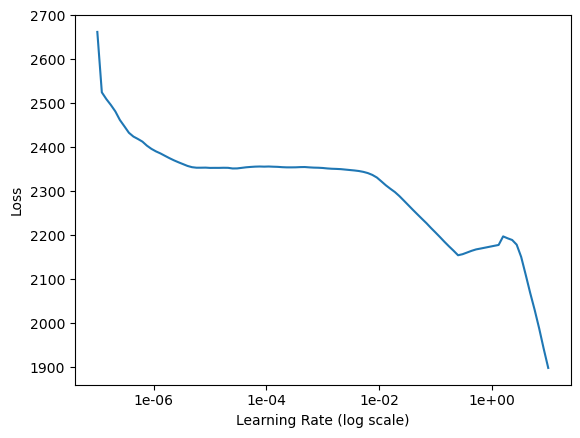

In [20]:
lr_finder.plot()

default high (including all news and dxy)
Epoch 193/300
90/90 [==============================] - 4s 40ms/step - loss: 7.0150 - mse: 135.8148 - val_loss: 8.4961 - val_mse: 182.4269

default low (including all news and dxy)
Epoch 191/300
90/90 [==============================] - 3s 39ms/step - loss: 7.9730 - mse: 169.2793 - val_loss: 10.2901 - val_mse: 291.6989

In [76]:
#test_steps = len(test_indices) // batch_size
# Generate predictions for the test set
high_model = tf.keras.saving.load_model('best_model_high.h5')
low_model = tf.keras.saving.load_model('best_model_low.h5')

high_predictions = high_model.predict(X_test)
low_predictions = low_model.predict(X_test)

# Create a dictionary with the arrays
data = {
    'date': pd.to_datetime(df_1T.iloc[data_indices].index.date[indices][split_index:]),
    'ph': high_predictions.reshape(len(high_predictions)),
    'h': y_test[:,0].reshape(len(y_test[:,0])),
    'pl': low_predictions.reshape(len(low_predictions)),
    'l': y_test[:,1].reshape(len(y_test[:,1]))
}

# Convert the dictionary to a DataFrame
res = pd.DataFrame(data).set_index('date').astype(float).round(2)
res['dh'] = res.h - res.ph
res['dl'] = res.pl - res.l

# Print the individual predictions with actual values
# for i in range(len(predicted_high)):
#     print(f"Sample {i+1} - {dates[i]} - Predicted/Actual High: {predicted_high[i]:.2f}, {actual_high[i]:.2f} Predicted/Actual Low: {predicted_low[i]:.2f}, {actual_low[i]:.2f}")


12/12 [==============================] - 1s 64ms/step


In [85]:
res[(res.dh > -2) & (res.dl > -2) & (res.index.year >= 2022)]

(363, 6)

In [106]:
sl = [1,2,3,4,5,6,7,8,9,10]
rr = [1,2,3,4,5,6,7,8,9,10]
total = res.shape[0]
for i in sl:
    for j in rr:
        long = res[(res.dl > -i) & (res.dl <= 0) & (res.h >= res.pl + j*i)].shape[0]
        short = res[(res.dh > -i) & (res.dh <= 0) & (res.l <= res.ph - j*i)].shape[0]
        total_return = (long + short)*j - (total - long - short)
        if total_return >= 0:
            print(f'SL: {i} - RR: {j} -- longs: {long}, shorts: {short}, total return: {total_return}')

SL: 4 - RR: 2 -- longs: 49, shorts: 75, total return: 9
SL: 5 - RR: 2 -- longs: 44, shorts: 77, total return: 0
SL: 6 - RR: 1 -- longs: 78, shorts: 122, total return: 37
SL: 7 - RR: 1 -- longs: 92, shorts: 128, total return: 77
SL: 8 - RR: 1 -- longs: 91, shorts: 134, total return: 87
SL: 9 - RR: 1 -- longs: 92, shorts: 132, total return: 85
SL: 10 - RR: 1 -- longs: 89, shorts: 123, total return: 61
